In [1]:
import os
import sys

# Set working directory
plant_clef_root = '/home/ffw/workspace/plantCLEF/'
os.chdir(plant_clef_root)

data_dir = os.path.join(plant_clef_root, 'data')

import numpy as np
import sklearn
import scipy
import scipy.misc
import time

import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *
import mcl

# Add the scatnet implementation to the system path
scatnet_path = '/home/ffw/workspace/thesis_scatnet/'
if scatnet_path not in sys.path:
    sys.path.append(scatnet_path)

import scattconvnet



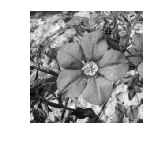

In [2]:
# configure plotting
plt.rcParams['figure.figsize'] = (2, 2)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

img = scipy.misc.imread('data/train/4013.jpg')[:600,:600,:]
img = scipy.misc.imresize(img,size=(256,256))
img = img[:,:,0]
plt.imshow(img[:,:]);
plt.axis('off');

In [3]:
import caffe
from caffe import layers as L
from caffe import params as P

In [4]:
use_gpu = True
if use_gpu:
    caffe.set_mode_gpu()
    caffe.set_device(0)
else:
    caffe.set_mode_cpu()

In [5]:
import mcl.nets.scatnet_net
reload(mcl.nets.scatnet_net)
from mcl.nets.scatnet_net import scatnet, gen_prototxt

f = gen_prototxt(scales=range(3),nangles=6, max_order=4)
print f

Total output dimensionality: 343
stride: 2
/tmp/tmpEty_67


In [6]:
net = scatnet(scales=range(3), max_order=4, nangles=6)

print "output: %s" % str(net.blobs['output'].data.shape)


print("params:")
for k in net.params.keys():
    print "%s: %s" %(k,net.params[k][0].data.shape)

Total output dimensionality: 343
stride: 2
output: (1, 343, 50, 50)
params:
scat0_real: (6, 1, 15, 15)
scat0_imag: (6, 1, 15, 15)
scat1_real: (36, 1, 15, 15)
scat1_imag: (36, 1, 15, 15)
scat2_real: (216, 1, 15, 15)
scat2_imag: (216, 1, 15, 15)
psi: (343, 1, 15, 15)


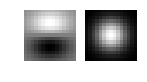

In [7]:
kernel_size = 15

for s in range(3):
    name = "scat%1i" % s
    for ai, a in enumerate(np.linspace(0,np.pi, 6,endpoint=False)):
        kernel = scattconvnet.wavelet.morlet(2**s,a,kernel_size+1)
        kernel = kernel[1:,1:]
        
        net.params[name+'_real'][0].data[ai::6,:,:,:] = np.real(kernel)
        net.params[name+'_imag'][0].data[ai::6,:,:,:] = np.imag(kernel)

        
gauss = scattconvnet.wavelet.gauss_kernel(3,16)[1:,1:]
net.params['psi'][0].data[:,:,:,:] = gauss

plt.subplot(1,2,1)
f = net.params[name+'_imag'][0].data[6,:,:,:]
plt.imshow(np.squeeze(f));
plt.axis('off');

plt.subplot(1,2,2)
f = net.params['psi'][0].data[310,:,:,:]
plt.imshow(np.squeeze(f));
plt.axis('off');
plt.show();


In [8]:
np.linspace(0,4,4,endpoint=False)

array([ 0.,  1.,  2.,  3.])

In [9]:
img_input = img[np.newaxis, np.newaxis, :, :].copy()

# Increase batch
for _ in range(0):
    img_input = np.append(img_input, img_input, 0)

#img_input = np.concatenate([img_input,
#                            img_input], 0)
print img_input.shape

net.blobs['data'].reshape(*img_input.shape)
net.blobs['data'].data[...] = img_input

(1, 1, 256, 256)


In [10]:
%%time
caffe.set_mode_gpu()
caffe.set_device(0)
for _ in range(1):
    net.forward()
pass

CPU times: user 156 ms, sys: 100 ms, total: 256 ms
Wall time: 141 ms


%%time
caffe.set_mode_cpu()
for _ in range(1):
    net.forward()
pass

In [11]:
output = np.squeeze(net.blobs['output'].data[0,:,:,:])

(343, 128, 128)


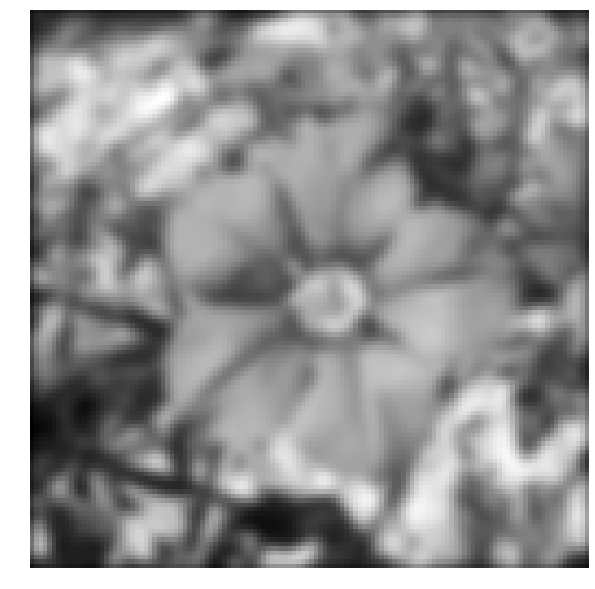

In [12]:
print output.shape
img = np.squeeze(output[0,:,:])
#img -= img.min()
#img /= img.max()

plt.figure(figsize=(10,10))
plt.imshow(img);
plt.axis('off');

In [13]:
tmp = output[:,64:192:2,64:192:2,np.newaxis].copy()

for l in range(tmp.shape[0]):
    mx = tmp[l].max()
    if mx == 0:
        continue
    if mx == np.inf:
        tmp[l] = 0
        continue
    tmp[l] / mx

tmp = np.concatenate([tmp,tmp,tmp],3)
    

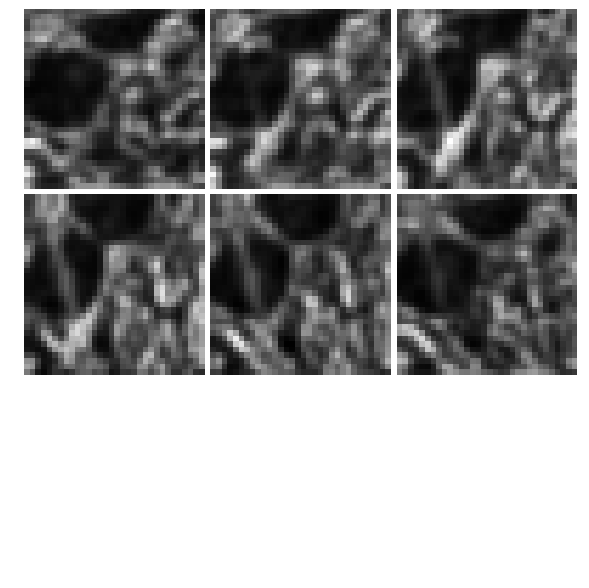

In [16]:
plt.figure(figsize=(10,10))
vis_square(tmp[1:7,:,:,:])